In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

# Loading data

In [99]:
air_data_RH14_ref = pd.read_csv("0-water-absortion/20230928-142109__eduardo__THZ55-70__PMP0__S2207L__14RH__297.5K__Air_reference.dat", sep="	")
air_data_RH64 = pd.read_csv("0-water-absortion/20230928-144546__eduardo__THZ55-70__PMP0__S2207L__64RH__297.4K__Air.dat", sep="	")
air_data_RH35 = pd.read_csv("0-water-absortion/20230928-150125__eduardo__THZ55-70__PMP0__S2207L__35RH__297.5K__Air.dat", sep="	")
air_data_RH23 = pd.read_csv("0-water-absortion/20230928-150647__eduardo__THZ55-70__PMP0__S2207L__23RH__297.5K__Air.dat", sep="	")
air_data_RH17 = pd.read_csv("0-water-absortion/20230928-151412__eduardo__THZ55-70__PMP0__S2207L__17RH__297.5K__Air.dat", sep="	")

In [100]:
dic_of_all_dataframes = {
    "air_data_RH14_ref": air_data_RH14_ref, "air_data_RH64": air_data_RH64, "air_data_RH35":air_data_RH35, "air_data_RH23":air_data_RH23, "air_data_RH17":air_data_RH17
    }

# Exploring the data

In [101]:
print(f"{air_data_RH64.head()}\n\ndata types\n{air_data_RH64.dtypes}\n\ndata shape\n{air_data_RH64.shape}")

      pos             X
0  55.000  2.046380e-12
1  55.005  2.955870e-12
2  55.010  2.501120e-12
3  55.015  2.728500e-12
4  55.020  2.955870e-12

data types
pos    float64
X      float64
dtype: object

data shape
(3001, 2)


# Constants

In [102]:
c = 3e8 # meter per second
free_path = 1.27 # meters
N = air_data_RH64.shape[0]
print(f"c = {c:.1e} m/s\nfree_path = {free_path} m \nN = {N}")

c = 3.0e+08 m/s
free_path = 1.27 m 
N = 3001


# Transforming the position column

The position column `pos` are positions from the delay line. Since the light speed is constant, we can transform the data to moment in time and set to a relative moment. I'll set $t=0$ the moment whose X is maximum. The times are calculated as:

$$
t_n = 2(x_n - x_0) / c,
$$

Where $x_n$ is the n-th position of the delay line and c is the speed of light. The factor 2 is because the displacement of the delay line doubles the beam path.

In [229]:
id_max_X = dic_of_all_dataframes['air_data_RH14_ref']['X'].idxmax()
for df in dic_of_all_dataframes.values():
    df['time_moment'] = (df['pos']-df['pos'][id_max_X])*2e-3/c

In [230]:
time_step = dic_of_all_dataframes["air_data_RH14_ref"]["time_moment"][1]-dic_of_all_dataframes["air_data_RH14_ref"]["time_moment"][0]
print(f"\ntime step = {time_step:1.1e} s")


time step = 3.3e-14 s


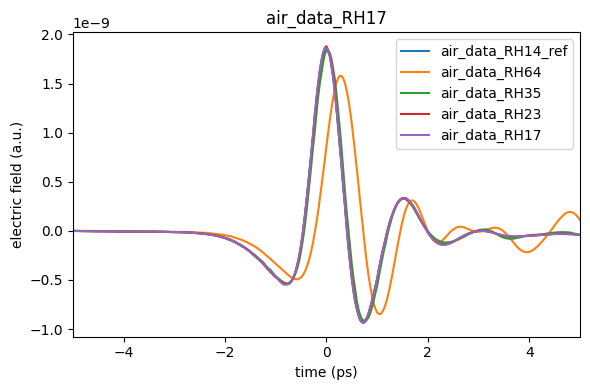

In [273]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
leg = []
for df_name, df in dic_of_all_dataframes.items():
    ax.plot(df['time_moment']*1e12, df['X'])
    ax.set_xlabel('time (ps)')
    ax.set_ylabel('electric field (a.u.)')
    ax.set_title(df_name)
    ax.set_xlim((-5,5))
    leg.append(df_name)
ax.legend(leg)
plt.show()

In [ ]:
t_0_RH14 = dic_of_all_dataframes['air_data_RH14_ref']['time_moment']
t_0_RH64 = dic_of_all_dataframes['air_data_RH64']['time_moment'][0]

print(f'peak delay (t0 RH 14% - t0 RH 64%)\n{(t_0_RH14-t_0_RH64)*1e12:1.2f} ps')

peak delay (t0 RH 14% - t0 RH 64%)
0.00 ps


# Fast Fourier Transform (FFT)

We can decompose the electric field into an integral of monochromatic plane waves:

$$
E(t) = \int^\infty_{-\infty}\tilde{E}(\omega)e^{-i\omega t}\text{d}t
$$

Therefore, to retrieve the spectral information, we should calculate the **Fourier Transform** of the electric field:

$$
\tilde{E}(\omega) = \frac{1}{2\pi}\int^\infty_{-\infty}E(t)e^{i\omega t} \text{d} \omega.
$$

Since the data we collect are not continuos, but discrete, we use an algorithm to calculate the **Discrete Fourier Transform**, which can be defined as:

$$
\tilde{E}_k = \frac{1}{N} \sum_{n=0}^{N-1} E_n e^{2 \pi i \omega_k\frac{n}{N}}.
$$

This algorithm is called **Fast Fourier Transform**, and it's calculated using the `scipy` package. Here I'm using the module `fftfreq` to calculate the frequencies. Since the data is equally spaced in time, it is quite easy to determine the frequencies:

$$
\omega_k = 
\begin{cases}
    \frac{k}{Nt_s}, \ k=-(N-1)/2,...,0,1,2,...,(N-1)/2, \hspace{16pt} \text {if} \ \ N \ \ \text{is odd}, \\
    \frac{k-1}{Nt_s}, \ k=-N/2,...,1,2,3,...,N/2, \hspace{66pt} \text{if} \ \ N \ \ \text {is even},
\end{cases}
$$
where $t_s$ is the time step. So, for each pair $(E_n, t_n)$ we have the corresponding pair $(\tilde{E}_k, \omega_k)$ calculated using the FFT algorithm. The spectrum is symmetric, so we only use the positive frequencies.

In [233]:
#dictionaries with all dataframes
dic_of_all_dataframes_fft = {key_name+"_fft": np.conj(fft(df['X'])) for key_name, df in dic_of_all_dataframes.items()}

In [234]:
# Using [:N//2] to use only the positive frequencies
freqs = fftfreq(N, time_step)[:N//2]

In [235]:
print(f'Time step: {time_step*1e12:1.3f} ps \nfrequency step: {(freqs[1] - freqs[0])*1e-9:1.3f} GHz')

Time step: 0.033 ps 
frequency step: 9.997 GHz


# Plotting the amplitude and phase

$\tilde{E}(\omega)$ is a complex number, hence it has an amplitude and a phase, both frequency dependent:

$$
\tilde{E}(\omega) = A(\omega)e^{i\phi(\omega)}
$$

The amplitude and phase are:

$$
A(\omega) = \sqrt{\tilde{E}(\omega)\tilde{E}^*(\omega)} = \sqrt{\text{Re}\{\tilde{E}(\omega)\}^2 + \text{Im} \{\tilde{E}(\omega)\}^2},
$$

$$
\phi(\omega) = \text{arg}[\tilde{E}(\omega)].
$$

A complex number can be interpreted geometrically, having a length and an angle, which are respectively the amplitude and phase. Using the functions `np.abs` and `np.angle` we can plot both amplitude and phase in function of frequency.

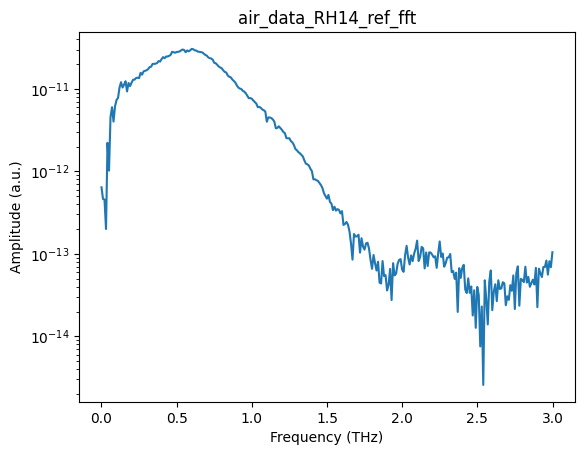

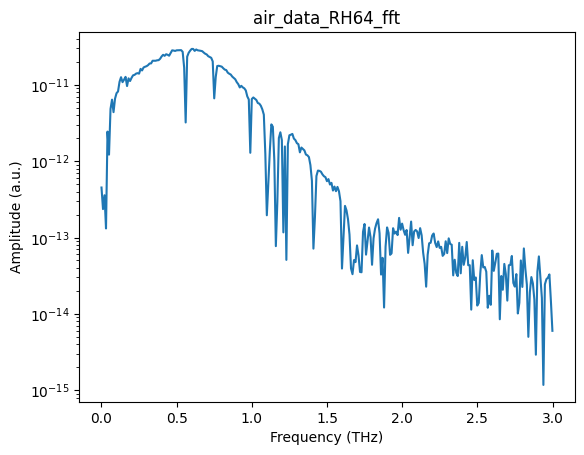

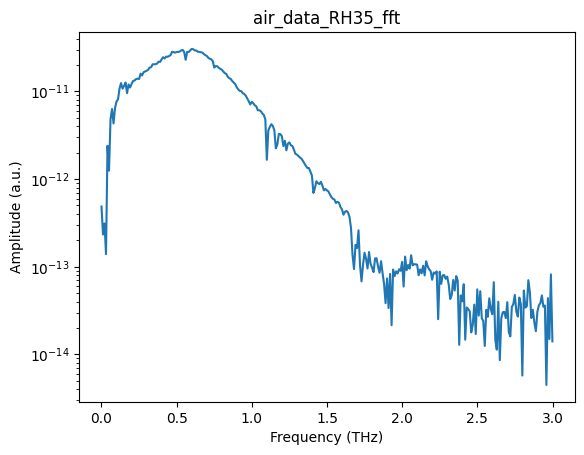

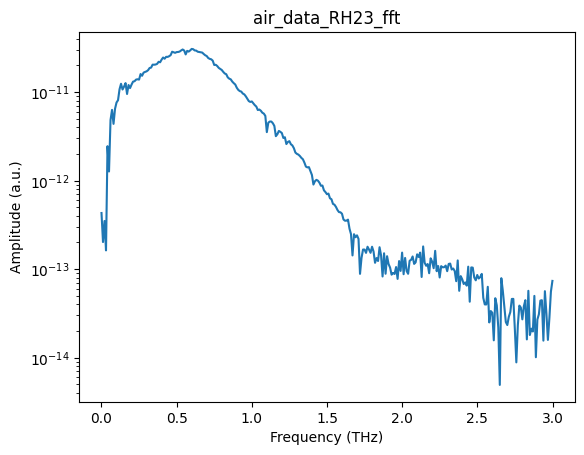

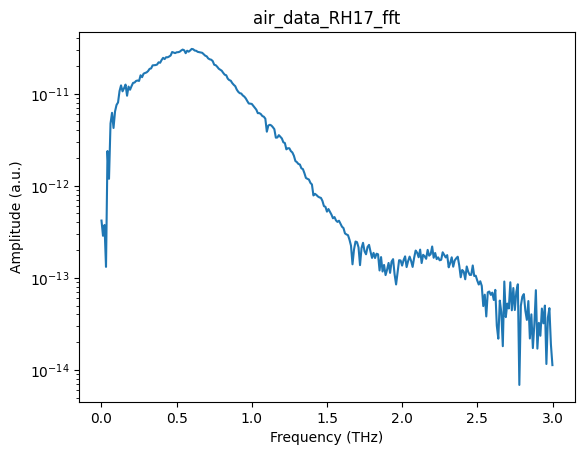

In [244]:
max_freq_id = len(freqs[freqs<3e12]) #plotting only frequencies below 3THz
for df_name, df in dic_of_all_dataframes_fft.items():
    y = 2.0/N * np.abs(df[:N//2])
    plt.semilogy(freqs[:max_freq_id]*1e-12, y[:max_freq_id])
    plt.title(df_name)
    plt.xlabel('Frequency (THz)')
    plt.ylabel('Amplitude (a.u.)')
    plt.show()

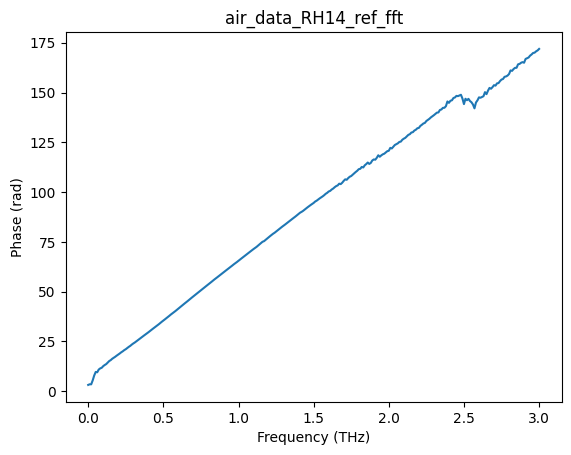

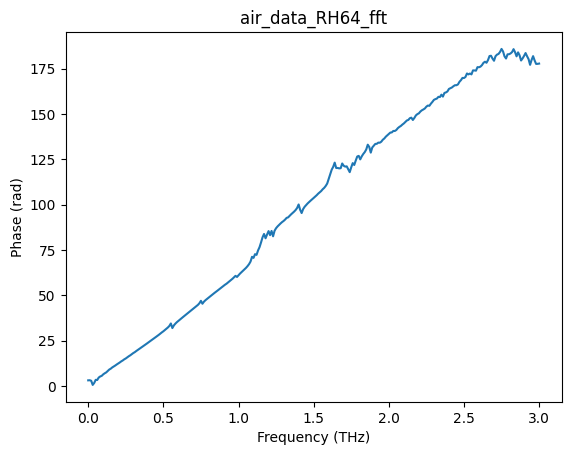

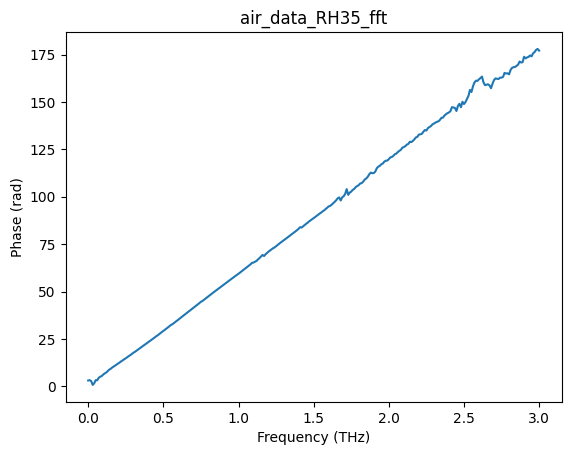

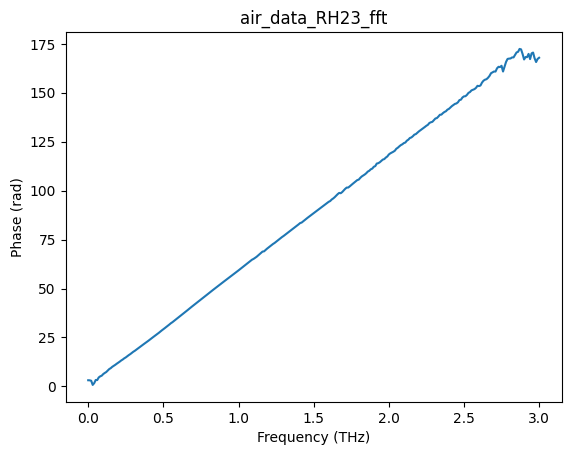

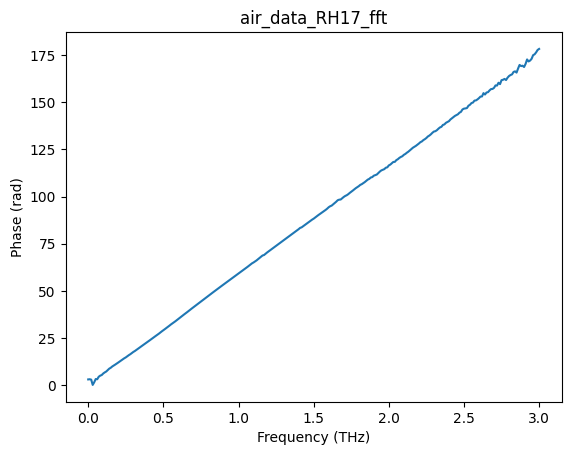

In [245]:
for df_name, df in dic_of_all_dataframes_fft.items():
    y = np.unwrap(np.angle(df[:N//2]))
    plt.plot(freqs[:max_freq_id]*1e-12, y[:max_freq_id])
    plt.title(df_name)
    plt.xlabel('Frequency (THz)')
    plt.ylabel('Phase (rad)')
    plt.show()

# Calculating the complex transmission coefficient

The data are actually proportional to the electric field, and not exactly it's amplitude. But it doesn't matter because this factor will vanish in our analysis, since we're interested in quantities such as the complex transmission coefficient, that is defined as: 

$$
\tilde{\mathcal{T}}(\omega) = \frac{\tilde{E}_a(\omega)}{\tilde{E}_{ref}(\omega)},
$$

where $\tilde{E}_a(\omega)$ stands for the electric field measured after the beam passed through a sample, and $\tilde{E}(\omega)$ the electric field without the sample, passing through a "free path".

We can calculate the transmission coefficient of water, since it abundant in the atmospheric air. I didn't mentioned before, but as we can see in the charts I plotted above, we have data for different air relative humidity (RH): 64%, 35%, 23%, 17% and 14%. We can estimate the complex transmission coefficient considering that the electric field through the air with RH 64% is the electric field through the "sample" and the electric field through the air with RH 14% without the "sample":

$$
\tilde{\mathcal{T}}_{H_2O}(\omega) = \frac{\tilde{E}_{RH64\%}(\omega)}{\tilde{E}_{RH14\%}(\omega)}.
$$

From the complex transmission coefficient we can calculate quantities such as the complex refractive index the complex electric permittivity:

$$
\begin{align}
\tilde{n}(\omega) = n(\omega) + i\kappa(\omega), \\
\tilde{\epsilon}(\omega) = \epsilon_1(\omega) + i\epsilon_2(\omega).
\end{align}
$$

The way we obtain the aforementioned quantities depends on what models we choose to interpret the data and whether they fit all conditions of the model. For the water present in atmospheric air we use the model for a **thick sample** without substrate. A sample is considered thick if the measurement is made **before** the first reflection arrives at the detector. Therefore, the time $\Delta t$ to this reflected wave gets at the detector should be lower than the duration of one terahertz pulse ($\Delta t > \tau_{THz}$). Despite the sample is considered thick, there's some signal being measured, so we can consider that there's no much absorption ($n(\omega) >> \kappa(\omega)$). Regarding that, the expression for the complex transmission coefficient for a sample without substrate,

$$
\tilde{\mathcal{T}} = \tilde{t_{01}}\tilde{t_{10}}\text{FP}_{d,010}^{\infty} \frac{p_{d,1}}{p_{d,0}},
$$

where $\tilde{n}_0(\omega)$ and $\tilde{n}_1(\omega)$ are the complex refractive indexes of air and the sample respectively, can be written using only the real part of the Fresnels coefficients:  

$$
\begin{align}
\mathcal{T} &= \sum_{m=0}^{\infty}\frac{4n_0n_1(n_1-n_0)^m}{(n_1+n_0)^{2m+1}}\exp{\left[i\frac{\omega d}{c}[(2m+1)\tilde{n}_1-\tilde{n}_0]\right]} = \\
&= \sum_{m=0}^{\infty}\frac{4n_0n_1(n_1-n_0)^m}{(n_1+n_0)^{2m+1}}\exp{\left[i\frac{\omega d}{c}[(2m+1)n_1-1]\right]}\exp{\left[- \frac{\omega d}{c}(2m+1)\kappa\right]}
\end{align}
$$

Considering the refractive index of air equals to 1 ($n_0 = 1$). Therefore, the phase $\varphi^{(m)}$ of the m-th reflection is:

$$
\varphi^{(m)} = \frac{\omega d}{c} ((2m+1)n-1).
$$

So, the phase difference between two subsequent reflections is:

$$
\Delta \varphi = \varphi^{(m+1)} - \varphi^{(m)} = \frac{2\omega nd}{c}.
$$

The time $\Delta t$ for this reflected wave to travel through all the sample is given by:

$$
\Delta t = \frac{\Delta \varphi}{\omega} = \frac{2nd}{c}.
$$

Typically, $\tau_{THz} \sim 10 \text{ps}$, which gives us $nd \approx 1.5 \text{mm}$. Here, the "sample" thickness, or the free path, is 1.27m, is much bigger than we need. In this context, we're measuring all before the first reflection, so we only use the first term of the sum in the expression of $\mathcal{T}$ (that is, $m=0$). That said, we have the expressions

$$
\begin{cases}
\mathcal{T}(n, \kappa, \omega) = \frac{4n}{(n+1)^2}e^{\frac{-\kappa \omega d}{c}} \\
\varphi(n, \omega) = \frac{\omega d}{c}(n-1)
\end{cases}
$$

Which gives us the direct expressions for $n(\omega)$ and $\kappa(\omega)$:

$$
\begin{cases}
n(\omega) = 1 + \frac{c}{\omega d}\varphi(\omega), \\
\kappa(\omega) = - \frac{c}{\omega d} \ln{\left[ \frac{(n(\omega)+1)^2}{5n(\omega)}\mathcal{T}(\omega) \right]}.
\end{cases}
$$

After this brief, kinda poor summary of some little part of Nicolas thesis, we have all we need to calculate and plot the absorption coefficient (which is related to the extinction coefficient $\kappa$, given by the expression below) and the refractive index of water!

$$
\alpha(\omega) = \frac{4\pi \kappa \omega}{c} = -\frac{2}{L}\ln{\left[\mathcal{T}(\omega)\right]}.
$$

In [238]:
dic_of_all_dataframes_fft_overRHref = {key+"_overRHref": df/dic_of_all_dataframes_fft["air_data_RH14_ref_fft"] for key, df in dic_of_all_dataframes_fft.items()}

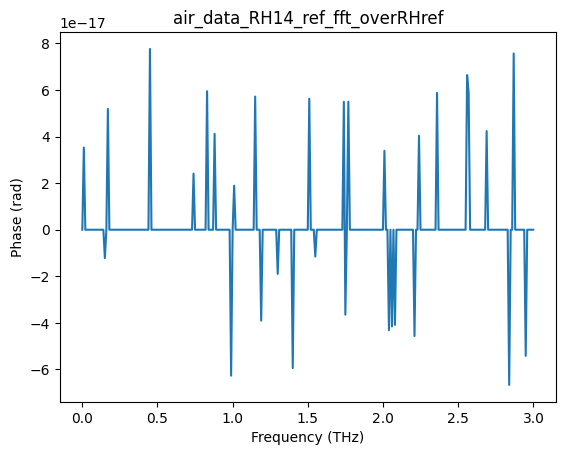

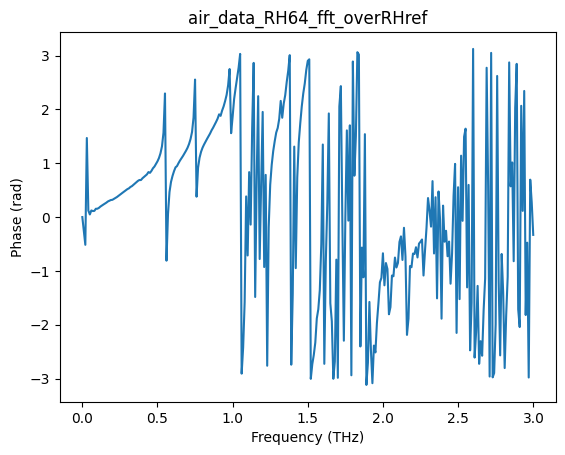

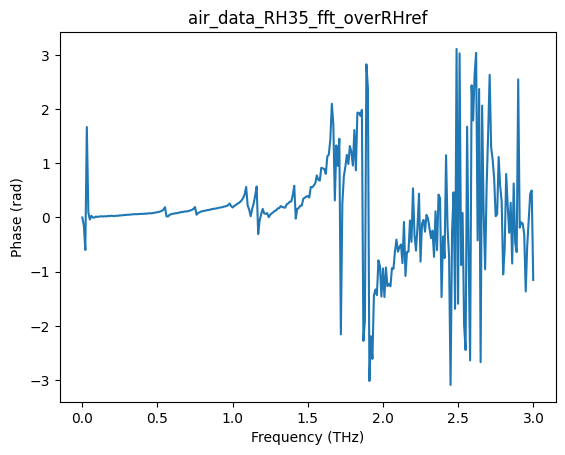

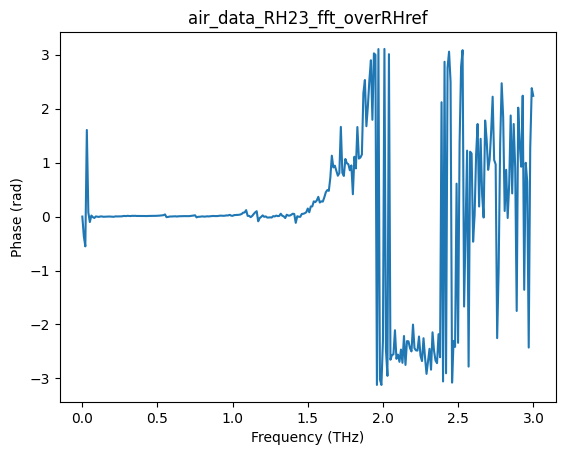

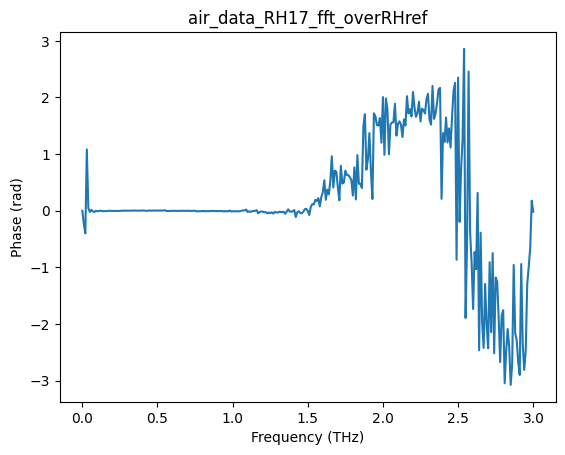

In [362]:
for df_name, df in dic_of_all_dataframes_fft_overRHref.items():
    y = np.angle(df[:N//2])
    plt.plot(freqs[:max_freq_id]*1e-12, y[:max_freq_id])
    plt.title(df_name)
    plt.xlabel('Frequency (THz)')
    plt.ylabel('Phase (rad)')
    plt.show()

# Phase unwrap

A complex number can be represented by a 2-dimensional vector, with one dimension purely real and the other purely complex. What we call "phase" of a complex number it's the angle that this vector make with the real axis.

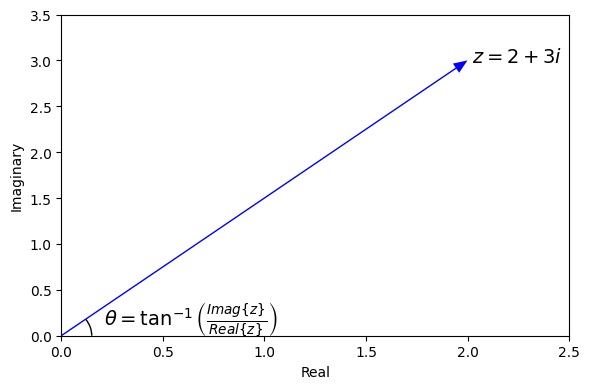

In [361]:
z = 2 + 3j
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
# ax.plot([0,z.real], [0,z.imag])
ax.annotate("",  
            xy=(z.real, z.imag),  
            xytext=(0, 0),         
            arrowprops=dict(
                facecolor='blue',  
                edgecolor='blue',
                shrink=0,         
                width=1,
                headwidth=8,       
                headlength=10,
                linewidth=0,
            ))
ax.set_xlim((0,2.5))
ax.set_ylim((0, 3.5))
ax.set_xlabel("Real")
ax.set_ylabel("Imaginary")
arc = plt.matplotlib.patches.Arc((0,0), .3, .6, angle=0, theta1=0, theta2 = np.angle(z)*180/np.pi)
ax.annotate(r"$\theta = \tan^{-1}\left(\frac{Imag\{z\}}{Real\{z\}}\right)$", xy=(.25,.25), xytext=(.21,.12), fontsize=14)
ax.annotate(r"$z=2+3i$", xy=(z.real,z.imag), xytext=(z.real+.02,z.imag-.02), fontsize=14)
ax.add_patch(arc)
plt.show()

When we use `np.angle(z)` to calculate the angle of the complex number `z`, the module returns a number between $-\pi$ and $\pi$, but the actual phase, the one we use to calculate the refraction index which is frequency dependent, can be greater (less) than $\pi$ ($-\pi$). To solve this we use the module `np.unwrap`, that "unwraps" the phase. This module calculates the 'step' of the phase, and if this step is outside the interval $[-\pi,\pi]$ the module corrects the phase:

In [240]:
# for df_name, df in dic_of_all_dataframes_fft_overRHref.items():
#     y = df[:N//2].imag
#     plt.semilogy(freqs[:max_freq_id]*1e-12, y[:max_freq_id])
#     plt.title(df_name)
#     plt.xlabel('Frequency (THz)')
#     plt.ylabel(f'$E_{df_name[11]}$'+f'$_{df_name[12]}$'+r'$_\%$'+r' / $E_{14\%}$')
#     plt.show()

In [241]:
#Complex transmission coefficient
T = dic_of_all_dataframes_fft_overRHref["air_data_RH64_fft_overRHref"]
#absorption coefficient
alpha = -2/free_path * np.log(np.abs(T))

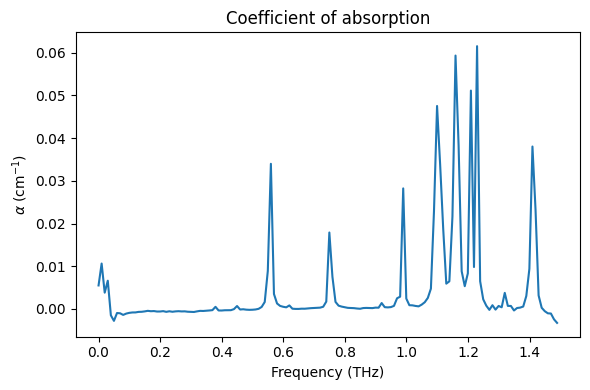

In [247]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(freqs[:max_freq_id//2]*1e-12, alpha[:max_freq_id//2]*1e-2)
ax.set_title("Coefficient of absorption")
ax.set_ylabel(r"$\alpha$ (cm$^{-1}$)")
ax.set_xlabel("Frequency (THz)")
plt.show()

In [282]:
alpha_and_frequencies_dataframe = pd.DataFrame({'freqs': freqs[:max_freq_id//2]*1e-12, 'alpha': alpha[:max_freq_id//2]*1e-2})
alpha_peaks = alpha_and_frequencies_dataframe.nlargest(100, 'alpha')

In [283]:
tolerance = 0.01 
pruned_peaks = [] 
alpha_peaks_cp = alpha_peaks.copy()
while not alpha_peaks_cp.empty:
    
    peak = alpha_peaks_cp.iloc[0]
    pruned_peaks.append(peak)
    
    
    peak_freq = peak['freqs']
    alpha_peaks_cp = alpha_peaks_cp[np.abs(alpha_peaks_cp['freqs'] - peak_freq) > tolerance]

final_peaks = pd.DataFrame(pruned_peaks)
final_peaks = final_peaks.sort_values(by='freqs').reset_index(drop=True)

In [284]:
final_peaks = final_peaks[final_peaks['alpha']>0.01]
print(len(final_peaks))

10


In [285]:
print('alpha (cm^-1)    frequency (THz)')
for i in range(0,len(final_peaks),1):
    alpha_p = final_peaks['alpha'].iloc[i]
    freq_p = final_peaks['freqs'].iloc[i]
    print(f'{alpha_p:1.3f}               {freq_p:1.3f}')

alpha (cm^-1)    frequency (THz)
0.011               0.010
0.034               0.560
0.018               0.750
0.028               0.990
0.048               1.100
0.019               1.120
0.059               1.160
0.051               1.210
0.062               1.230
0.038               1.410


# Index refraction of water

In [252]:
n_h2O = 1+c/(2*np.pi*freqs[10:]*free_path)*np.unwrap(np.angle(T[10:N//2]))
# n_h2O = np.unwrap(np.angle(T[10:N//2]), discont=np.pi)
# n_h2O = np.angle(T[10:N//2])

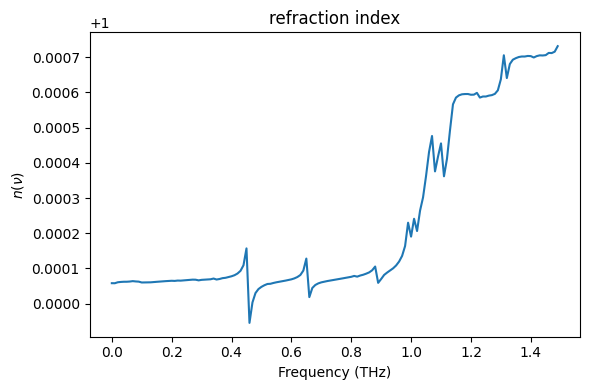

In [254]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(freqs[:max_freq_id//2]*1e-12, n_h2O[:max_freq_id//2])
ax.set_title("refraction index")
ax.set_ylabel(r"$n(\nu$)")
ax.set_xlabel("Frequency (THz)")
plt.show()

In [295]:
pi = np.pi
phase_test = [0, pi/2,pi,-pi/2,-pi, -2*pi, -pi/2]
unwrap_phase_test = np.unwrap(phase_test)
print(phase_test)
print(unwrap_phase_test)

[0, 1.5707963267948966, 3.141592653589793, -1.5707963267948966, -3.141592653589793, -6.283185307179586, -1.5707963267948966]
[ 0.          1.57079633  3.14159265  4.71238898  3.14159265  0.
 -1.57079633]


In [292]:
print(3*pi/2)

4.71238898038469
